# Project 2 - Open-domain Question Answering: Answer Sentence Selection

**Introduction**

Answer sentence selection is the task of identifying sentences that contain the answer to a given question. This is an important problem in its own right as well as in the larger context of open domain question answering. Question Answering uses either large-scale knowledge base (e.g., Freebase) or free, high-quality, reliable text (e.g., Wikipedia, news articles). In this project we use the latter (i.e., Wikipedia) to select the potential answers from.

**Problem Statement**

Given a factoid question, find the sentence in the candidate set that (1) contains the answer; and (2) can sufficiently support the answer. 

**Dataset: WikiQA Corpus**

WIKIQA is a dataset for open domain question answering. The dataset contains over 3,000 questions originally sampled from Bing query logs. Based on the user clicks, each question is associated with a Wikipedia page presumed to be the topic of the question. all the sentences in the summary paragraph of the page as the candidate answer sentences, with labels on whether the sentence is a correct answer to the question provided by crowdsourcing workers. Among these questions, about one-third of them contain correct answers in the answer sentence set.

**Metrics**

Precision, recall and F1 scores for answer triggering problem.

**Methodology**

After cleaning data and reading them into DataFrames from *.tsv files and some exploratory data analysis, we convert the texts to TF-IDF (for question query) and USE vectors (for sentece selction). We will then use Linear and Logistic Regression to match the questions and right answers. We will then a fit DNN model using Keras API to further improve the classification metrics.


In [7]:
# Import all modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

## Data prepration, wrangling, and EDA

In [8]:
# reading data to into a dataframe
data_file_path = "Data/WikiQA.tsv"
orig_df = pd.read_csv(data_file_path, sep='\t')

In [9]:
orig_df.head()

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label
0,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-0,African immigration to the United States refer...,0
1,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-1,The term African in the scope of this article ...,0
2,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-2,From the Immigration and Nationality Act of 19...,0
3,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-3,African immigrants in the United States come f...,0
4,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-4,"They include people from different national, l...",0


In [10]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29208 entries, 0 to 29207
Data columns (total 7 columns):
QuestionID       29208 non-null object
Question         29208 non-null object
DocumentID       29208 non-null object
DocumentTitle    29208 non-null object
SentenceID       29208 non-null object
Sentence         29208 non-null object
Label            29208 non-null int64
dtypes: int64(1), object(6)
memory usage: 1.6+ MB


In [11]:
n_questions = orig_df.QuestionID.nunique()
print("Number of questions in the whole dataset: ", n_questions)

Number of questions in the whole dataset:  3044


In [12]:
n_wikidoc = orig_df.DocumentTitle.nunique()
print("Number of Wikipedia pages in the whole dataset: ", n_wikidoc)

Number of Wikipedia pages in the whole dataset:  2809


In [13]:
n_sentence = orig_df.SentenceID.nunique()
print("Number of sentences taken from wikipedia documents in the whole dataset: ", n_sentence)

Number of sentences taken from wikipedia documents in the whole dataset:  26239


In [54]:
print("Number of correct answers, i.e., Lebel=1: ", orig_df.Label.sum())

Number of correct answers, i.e., Lebel=1:  1469


#### NOTE: The dataset is significantly imbalanced with only 5% Label =1 and 95% Label = 0.

count    3044.000000
mean        9.595269
std         6.254105
min         1.000000
25%         5.000000
50%         8.000000
75%        13.000000
max        30.000000
Name: DocumentID, dtype: float64

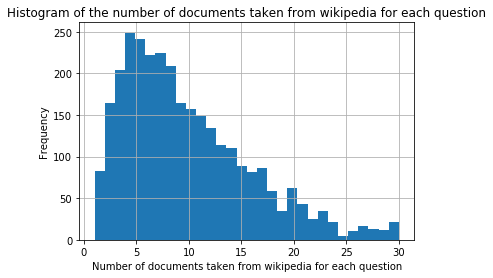

In [14]:
n_doc_per_question = orig_df.groupby('QuestionID').count().DocumentID
n_doc_per_question.hist(bins=30);
plt.title("Histogram of the number of documents taken from wikipedia for each question")
plt.xlabel('Number of documents taken from wikipedia for each question')
plt.ylabel('Frequency')
n_doc_per_question.describe()

count    2809.000000
mean       10.398006
std         9.482046
min         1.000000
25%         5.000000
50%         8.000000
75%        14.000000
max       203.000000
Name: SentenceID, dtype: float64

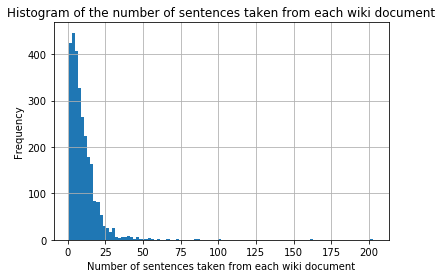

In [15]:
n_sentence_per_doc = orig_df.groupby('DocumentID').count().SentenceID
n_sentence_per_doc.hist(bins=100);
plt.title("Histogram of the number of sentences taken from each wiki document")
plt.xlabel('Number of sentences taken from each wiki document')
plt.ylabel('Frequency')
n_sentence_per_doc.describe()

count    3044.000000
mean        0.482589
std         0.680240
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         7.000000
Name: Label, dtype: float64

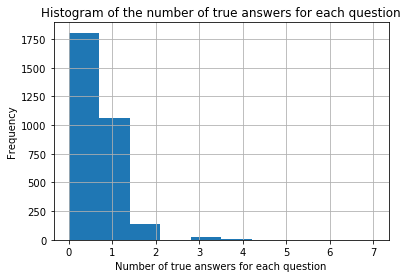

In [16]:
n_true_answers_per_question = orig_df.groupby('QuestionID').sum().Label
n_true_answers_per_question.hist(bins=10);
plt.title("Histogram of the number of true answers for each question")
plt.xlabel('Number of true answers for each question')
plt.ylabel('Frequency')
n_true_answers_per_question.describe()

In [17]:
questions = orig_df.drop_duplicates(subset=['QuestionID', 'Question']).loc[:,['QuestionID', 'Question']]
questions.reset_index(drop=True)
questions.index = questions.QuestionID
questions = questions.drop('QuestionID', axis=1)
questions.head()

,Question
QuestionID,
Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US
Q1,how are glacier caves formed?
Q2,How are the directions of the velocity and for...
Q3,how large were early jails
Q4,how a water pump works


In [18]:
valid_qa_df = orig_df[orig_df['Label'] == 1]

In [19]:
valid_qa_df.head()

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label
5,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-5,"As such, African immigrants are to be distingu...",1
9,Q1,how are glacier caves formed?,D1,Glacier cave,D1-3,A glacier cave is a cave formed within the ice...,1
33,Q4,how a water pump works,D4,Pump,D4-4,Pumps operate by some mechanism (typically rec...,1
80,Q11,"how big is bmc software in houston, tx",D11,BMC Software,D11-3,"Employing over 6,000, BMC is often credited wi...",1
81,Q11,"how big is bmc software in houston, tx",D11,BMC Software,D11-4,"For 2011, the company recorded an annual reven...",1


## Feature Extraction

### TF-IDF Vectorization: Question Query

In [20]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(questions.Question)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [56]:
# TF-IDF matrix for questions
question_tfidf_matrix = vectorizer.transform(questions.Question).todense()
print("Shape of the TF-IDF matrix for questions:", question_tfidf_matrix.shape)
# TF-IDF matrix to DataFrame for questions
question_tfidf_df = pd.DataFrame(question_tfidf_matrix, columns=vectorizer.get_feature_names(), index=questions.index)
question_tfidf_df.head()

Shape of the TF-IDF matrix for questions: (3044, 16764)


,000,000 of,0b,10,10 bill,10 cost,10 counting,10 dollar,10 net,10 vinyl,...,zoom range,zsa,zsa gabor,zsa zsa,zuko,zuko in,zune,zune run,zx3,zx3 have
QuestionID,,,,,,,,,,,,,,,,,,,,,
Q0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Example query
query = "How glacier made"

# TF-IDF vector for the query string
query_tfidf_matrix = vectorizer.transform([query]).todense()

# Find dot product of the TF-IDF matrix for question and the TF-IDF vector for the quesry string
result_df = question_tfidf_df.dot(query_tfidf_matrix.transpose())
result_df.columns = ['result']

print("Returned questions ... \n")
print(questions.loc[result_df.result.idxmax(axis = 0),:]) 
print("\ndotproduct result: %0.2f" % result_df.result.max())

Returned questions ... 

Question    how are glacier caves formed?
Name: Q1, dtype: object

dotproduct result: 0.36


## Feature Extraction
### USE Vectorization: Question - Correct Answer Matching

#### For Label = 1 entries (Q&As with at least one correct answer)

In [24]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"

# Import the Universal Sentence Encoder's TF Hub module
model = hub.load(module_url)
print ("module %s loaded" % module_url)

def embed(input):
    return model(input)

module https://tfhub.dev/google/universal-sentence-encoder-large/5 loaded


In [25]:
questions_use_vec = embed(list(valid_qa_df.Question))
sentences_use_vec = embed(list(valid_qa_df.Sentence))

In [26]:
questions_use_vec = np.array(questions_use_vec)
sentences_use_vec = np.array(sentences_use_vec)

## Linear Regression: Question - Correct Answer Matching

In [27]:
vec_train, vec_test, output_train, output_test = train_test_split(
    questions_use_vec, sentences_use_vec,test_size=0.05,random_state=0)

In [28]:
# instantiate the model (using the default parameters)
linreg = LinearRegression()

# fit the model with data
linreg.fit(vec_train, output_train)

# Predictions
output_pred_test = linreg.predict(vec_test)
output_pred_train = linreg.predict(vec_train)

In [55]:
# Note from the call (Use the USE vector as a search inside db):
# 1. check the accuracy, confusion matrix (if > 80%, proceed)
# 2. argmax on the entire sentence database 
# 3. Write the report (comparing the two accuracy numbers, etc.)
# ----- time permitting --- 
# 4. Gather more Wiki sentences. Package: wikipediaapi (particular topic datasceince, AI, robotics - 10 questions) 
#    to chekch the robustness.
# 5. Add more noise by adding similar questions
# 6. (out of scope maybe) auto-encoder with a much larger dataset: LSTM, BERT


In [30]:
true_test_sentenceIDs = valid_qa_df.iloc[output_test.dot(sentences_use_vec.transpose()).argmax(axis=1),4] 
pred_test_sentenceIDs = valid_qa_df.iloc[output_pred_test.dot(sentences_use_vec.transpose()).argmax(axis=1),4] 

In [31]:
true_train_sentenceIDs = valid_qa_df.iloc[output_train.dot(sentences_use_vec.transpose()).argmax(axis=1),4] 
pred_train_sentenceIDs = valid_qa_df.iloc[output_pred_train.dot(sentences_use_vec.transpose()).argmax(axis=1),4] 

In [32]:
train_accuracy = metrics.accuracy_score(true_train_sentenceIDs, pred_train_sentenceIDs)
print("Train Accuracy:", train_accuracy)

test_accuracy = metrics.accuracy_score(true_test_sentenceIDs, pred_test_sentenceIDs)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.8422939068100358
Test Accuracy: 0.47297297297297297


## Feature Extraction
### USE Vectorization: Answer Sentence Selection

#### For all labels, i.e., Label = 0 and 1 entries

In [33]:
# Commented the following codes to skip long USE compute and load the saved csv files instead
if 1==2:
    # Get the USE vectors for all the 3044 questions
    all_questions_use_vec = embed(list(questions.Question))

In [34]:
# Commented the following codes to skip long USE compute and load the saved csv files instead
if 1==2:

    # split the 29208 sentences into chunks of 500 sentences to prevernt ipython kernel death! 
    def chunks(l, n):
        """Yield successive n-sized chunks from list l."""
        for i in range(0, len(l), n):
            yield l[i:i + n]

    all_sentences_use_vec = np.empty([0, 512])
    
    # Get the USE vectors for all the 29208 sentences
    for chunk in chunks(list(orig_df.Sentence), 500):
        all_sentences_use_vec = np.append(all_sentences_use_vec, embed(chunk), axis=0)


In [35]:
# Commented the following codes to skip long USE compute and load the saved csv files instead
if 1==2:
    # saving the USE vectors of the sentences and questions in two csv files for future use
    np.savetxt("sentences_use_vec.csv", all_sentences_use_vec, delimiter=",")
    all_questions_use_vec = np.array(all_questions_use_vec)
    np.savetxt("questions_use_vec.csv", all_questions_use_vec, delimiter=",")

In [36]:
# Load USE vectors from csv files for questions and sentences into numpy arrays 

all_sentences_use_vec = np.genfromtxt('sentences_use_vec.csv', delimiter=',')  # a (29208, 512) array#
all_questions_use_vec = np.genfromtxt('questions_use_vec.csv', delimiter=',')  # a (3044, 512) array

# build an array of 29208 questions to be concatenated to the array of sentences horizentally

ques_use = np.empty([len(orig_df), 512])

for idx, row in orig_df.iterrows():
    idx_ = questions.index.get_loc(row.QuestionID)
    ques_use[idx] = all_questions_use_vec[idx_]

# concatenate 512-dimenstion USE vectors of questions and senences 
# A new vector of 1024 elements for a (question, sentence)

ques_sent_use = np.concatenate((ques_use, all_sentences_use_vec), axis=1)
ques_sent_use.shape

(29208, 1024)

### Vizulization of USE vectors for correspoding (Question, Answer) pairs

In [115]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
pca_components_questions = pca.fit_transform(ques_use) # (29208, 1) array
pca_components_sentences = pca.fit_transform(all_sentences_use_vec)  # (29208, 1) array

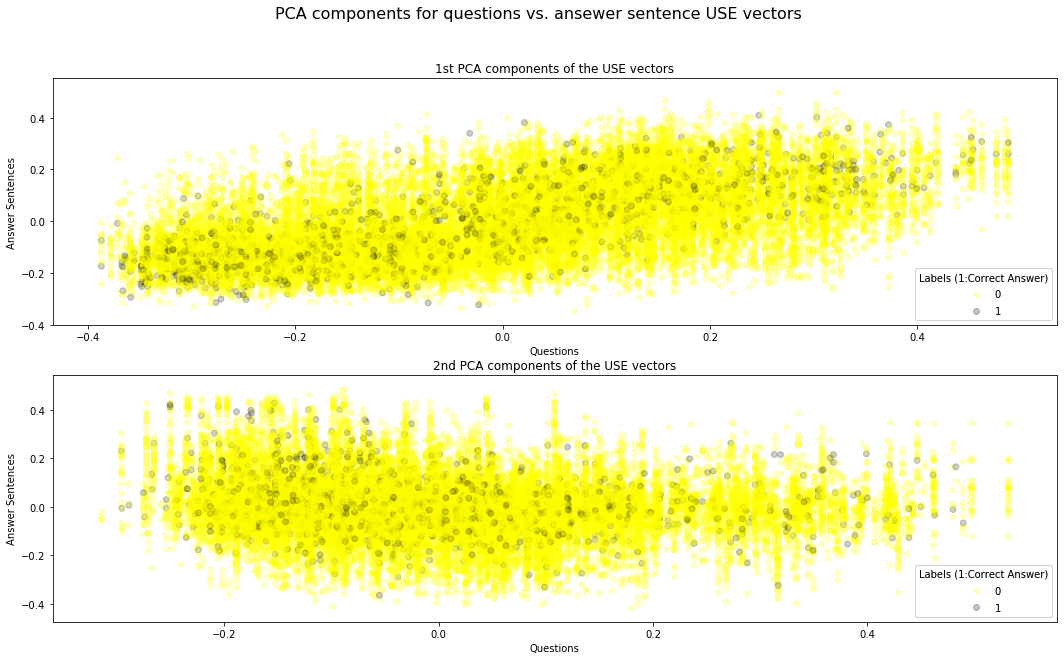

<Figure size 432x288 with 0 Axes>

In [130]:
from matplotlib.colors import ListedColormap

fig = plt.figure(figsize=(18,10))
c = np.array(orig_df.Label).transpose()*1.0
colors = ['yellow', 'black']

ax0 = plt.subplot(2, 1, 1)
plt.suptitle("PCA components for questions vs. ansewer sentence USE vectors", size=16)
scatter0 = plt.scatter(pca_components_questions[:,0], 
            pca_components_sentences[:,0], 
            alpha=0.2, c=c, cmap=ListedColormap(colors))
legend0 = ax0.legend(*scatter0.legend_elements(),
                    loc="lower right", title="Labels (1:Correct Answer)")
ax0.add_artist(legend0)
plt.title('1st PCA components of the USE vectors')
plt.xlabel('Questions')
plt.ylabel('Answer Sentences')

ax1 = plt.subplot(2, 1, 2)
scatter1 = plt.scatter(pca_components_questions[:,1], 
            pca_components_sentences[:,1], 
            alpha=0.2, c=c, cmap=ListedColormap(colors))
plt.title('2nd PCA components of the USE vectors')
plt.xlabel('Questions')
plt.ylabel('Answer Sentences')
legend1 = ax1.legend(*scatter1.legend_elements(),
                    loc="lower right", title="Labels (1:Correct Answer)")
ax1.add_artist(legend1)

plt.show()
plt.tight_layout()

**It appears that the 1st PCA component exhbits a better correleation between the question and answer pairs. The 1st PCA components for (question, correct answers) pairs are even more strongly correlated.**

In [118]:
pca_components_questions[:,0].shape

(29208,)

## Logistic Regression:  Answer Sentence Selection
### For all entries (both Lable = 0 and 1)

In [37]:
vec_train, vec_test, label_train, label_test = train_test_split(
    ques_sent_use, orig_df.Label, test_size=0.15, random_state=0, stratify=orig_df['Label'])

# instantiate the model (using the default parameters)
logreg = LogisticRegression(solver='liblinear', multi_class='auto', class_weight='balanced')

# fit the model with data
logreg.fit(vec_train,label_train)

# Predictions
label_pred_test = logreg.predict(vec_test)
label_pred_train = logreg.predict(vec_train)

In [38]:
accuracy_train = metrics.accuracy_score(label_train, label_pred_train)
print("Train Accuracy:", accuracy_train)

accuracy_test = metrics.accuracy_score(label_test, label_pred_test)
print("Test Accuracy:", accuracy_test)

Train Accuracy: 0.7796664786916941
Test Accuracy: 0.7690552259242355


In [39]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import roc_auc_score

classes = np.unique(label_test)
cnf_matrix = metrics.confusion_matrix(label_test, label_pred_test, labels=classes)
cnf_matrix = pd.DataFrame(cnf_matrix, columns=classes)
cnf_matrix.rename(index={i:k for i, k in enumerate(classes)}, inplace=True)

print("Note: Columns (predictions) vs. Rows (actuals)\n")
print(cnf_matrix)

Note: Columns (predictions) vs. Rows (actuals)

      0    1
0  3227  935
1    77  143


In [40]:
# Print f1, precision, and recall scores
print("Precision: ", precision_score(label_test, label_pred_test, average="macro"))
print("Recall: ", recall_score(label_test, label_pred_test, average="macro"))
print("F1: ", f1_score(label_test, label_pred_test, average="macro"))
print("Balanced Accuracy: ", balanced_accuracy_score(label_test, label_pred_test))
print("ROC AUC: ", roc_auc_score(label_test, label_pred_test, average="macro"))

Precision:  0.5546739882393635
Recall:  0.7126741950985103
F1:  0.5423955831407465
Balanced Accuracy:  0.7126741950985103
ROC AUC:  0.7126741950985103


## DNN: Using pre-trained USE word embeddings in a Keras model
### Answer Sentence Selection

In [41]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))

from keras import layers
from keras.models import Model
import sys

sys.setrecursionlimit(10000)

input_question = layers.Input(shape=(1,), dtype=tf.string)
input_sentence = layers.Input(shape=(1,), dtype=tf.string)
embedding_question = layers.Lambda(UniversalEmbedding, output_shape=(512,))(input_question)
embedding_sentence = layers.Lambda(UniversalEmbedding, output_shape=(512,))(input_sentence)
embedding = layers.concatenate([embedding_question, embedding_sentence])
dense = layers.Dense(256, activation='relu')(embedding)
pred = layers.Dense(1, activation='sigmoid')(dense)
nn_model = Model(inputs=[input_question, input_sentence], outputs=pred)
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Using TensorFlow backend.


In [42]:
nn_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512)          0           input_2[0][0]                    
____________________________________________________________________________________________

In [43]:
text_train, text_test, label_train, label_test = train_test_split(
    orig_df[['Question', 'Sentence']], orig_df['Label'], 
    test_size=0.15, random_state=0, stratify=orig_df['Label'])


In [49]:
from sklearn.utils import class_weight

#inputs

input_texts = [np.array(text_train.Question), np.array(text_train.Sentence)]
validation_texts = [np.array(text_test.Question), np.array(text_test.Sentence)]
y_train = label_train
y_test = label_test

# class weightes to deal with imbalanced training set
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', 
                                                                 np.unique(y_train), 
                                                                 y_train)))
# fit the NN model
history = nn_model.fit(input_texts, y_train, 
                       validation_data=(validation_texts, y_test),
                       epochs=6, batch_size=128, class_weight=class_weights)

# save the model for future use
nn_model.save_weights('./model.h5')

Train on 24826 samples, validate on 4382 samples
Epoch 1/6
24826/24826 [==============================] - 1245s 50ms/step - loss: 0.3141 - accuracy: 0.8486 - val_loss: 0.3889 - val_accuracy: 0.8147
Epoch 2/6
24826/24826 [==============================] - 1238s 50ms/step - loss: 0.2795 - accuracy: 0.8638 - val_loss: 0.3393 - val_accuracy: 0.8432
Epoch 3/6
24826/24826 [==============================] - 1234s 50ms/step - loss: 0.2491 - accuracy: 0.8788 - val_loss: 0.3289 - val_accuracy: 0.8505
Epoch 4/6
24826/24826 [==============================] - 1232s 50ms/step - loss: 0.2220 - accuracy: 0.8952 - val_loss: 0.3325 - val_accuracy: 0.8464
Epoch 5/6
24826/24826 [==============================] - 1235s 50ms/step - loss: 0.1959 - accuracy: 0.9094 - val_loss: 0.3445 - val_accuracy: 0.8453
Epoch 6/6
24826/24826 [==============================] - 1235s 50ms/step - loss: 0.1715 - accuracy: 0.9206 - val_loss: 0.2728 - val_accuracy: 0.8873


In [50]:
y_pred_ = nn_model.predict(validation_texts)

In [51]:
from sklearn.metrics import f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score


threshold = 0.5
y_pred = (y_pred_ > threshold).astype(np.int)

# Print f1, precision, and recall scores 
print("Precision: ", precision_score(y_test, y_pred, average="macro"))
print("Recall: ", recall_score(y_test, y_pred, average="macro"))
print("F1: ", f1_score(y_test, y_pred, average="macro"))
print("Balanced Accuracy: ", balanced_accuracy_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred, average="macro"))

Precision:  0.5998860229186347
Recall:  0.7124787034205583
F1:  0.6271809840442937
Balanced Accuracy:  0.7124787034205583
ROC AUC:  0.7124787034205583


In [52]:
from sklearn.metrics import confusion_matrix


classes = np.unique(y_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=classes)
cnf_matrix = pd.DataFrame(cnf_matrix, columns=classes)
cnf_matrix.rename(index={i:k for i, k in enumerate(classes)}, inplace=True)

print("Note: Columns (predictions) vs. Rows (actuals)\n")
print(cnf_matrix)

Note: Columns (predictions) vs. Rows (actuals)

      0    1
0  3774  388
1   106  114


In [ ]:
# Oversampling (label=1)
# Undersampling (lable=0)
# better: 
# Nima: Sampling rate tunning between oversample label = 1 and undersample label = 0
# Hobson: class_weight = 'auto' argument in the learning function
# change mertic from accuracy to 